In [1]:
# LIME Repeatability

import warnings
warnings.filterwarnings('ignore')

import shutil
import tensorflow as tf

from heatmaps_utils import *
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [2]:
## GPU config
gpus = [0]
configtf = tf.ConfigProto(allow_soft_placement=True)
configtf.gpu_options.allow_growth = True
configtf.gpu_options.visible_device_list = ','.join(str(gpu) for gpu in gpus)
init = tf.global_variables_initializer()
sess = tf.Session(config=configtf)
sess.run(init)

In [3]:
EXPERIMENT_TYPE='LIME_repeatability_pannuke'

In [4]:
# SET PROCESS TITLE
import setproctitle
setproctitle.setproctitle(EXPERIMENT_TYPE)

In [5]:
#LOAD MODEL
global model
import model_utils
reload(model_utils)
from model_utils import *
model=get_baseline_model()

In [6]:
model.load_weights('/mnt/nas2/results/IntermediateResults/Mara/EDLAI2020_ICPR/pannuke_baseline_IV3_100epochs/best_model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
import os
res_folder = 'results/'
new_folder = res_folder + EXPERIMENT_TYPE
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
#shutil.copy2(src=CONFIG_FILE, dst=os.path.join(new_folder, '.'))

In [8]:
import os
import sys
res_folder = 'results/'
new_folder = res_folder + EXPERIMENT_TYPE
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
#shutil.copy2(src=CONFIG_FILE, dst=os.path.join(new_folder, '.'))
import h5py as hd
# DATA PATHS
cam16 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/cam16_500/patches.hdf5', 'r')
all500 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/all500/patches.hdf5', 'r')
extra17 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/extra17/patches.hdf5', 'r')
tumor_extra17=hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/1129-1155/patches.hdf5','r')
test2 = hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/ultrafast/test_data2/patches.hdf5','r')
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/patches.hdf5', 'r',)
#
global data
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

# DATA SPLIT CSVs
train_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/train_shuffle.csv', 'r')
val_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/val_shuffle.csv', 'r')
test_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('/mnt/nas2/results/IntermediateResults/Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()

data_csv=open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/pannuke_train_shuffled.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()
sys.path.append('/home/mara/multitask_adversarial/lib/TASK_2_UC1/')
from normalizers import ReinhardNormalizer

In [9]:
import sys
sys.path.append('/home/mara/multitask_adversarial/lib/TASK_2_UC1/')
from normalizers import ReinhardNormalizer

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))

def get_keys(l):
    db_name=l.split(', ')[0]
    entry_path=l.split(', ')[1]
    patch_no=l.split(', ')[2]
    return db_name, entry_path, int(patch_no)

def get_class_name(entry_path):
    return entry_path.split('/')[0]

def load_patch_mask(patch_address, patch_idx, source_fld=''):
    mask=np.zeros((224,224,4))
    patch_path=source_fld+'/{}'.format(patch_idx) 
    #import pdb; pdb.set_trace()
    try:
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei
    except:
        patch_path=source_fld+patch_address.split('/node')[0]+'/{}'.format(patch_idx)
        #print patch_path
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei

# LOAD DATA NORMALIZER
global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = data[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder=new_folder)

Using brightness standardization
Normalisers saved to disk.


In [10]:
input_size = model.input_shape[1:-1]

In [11]:
# pertubed_images = []
# pertubed_images_preds = []

def predict(patches, normalizer=normalizer):
    inputs = []
    for patch in patches:
        inputs.append(normalize_patch(patch, normalizer))
    inputs = np.asarray(inputs, dtype=np.float32)
    inputs = preprocess_input(inputs)
#     pertubed_images.extend(patches)
#     pertubed_images_preds.extend(preds)
    return model.predict(inputs)

In [12]:
# Segmentation methods used to compute superpixels needed for LIME
seg_methods = {'Quickshift':segments_quick,
               'SLIC':segments_slic,
               'Felzenszwalb':segments_fz,
              }

def compute_avg(heatmaps):
    _tmp = heatmaps['SLIC'] + heatmaps['Felzenszwalb']
    _tmp /= 2
    heatmaps['AVG'] = _tmp
    return heatmaps

# Boxes size should be a divisor of input size
# Too high sizes will give too small boxes and low weights
# for computing Squaregrid (so no impact)
# They used 3/4/6/8/12/16/24 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6651753/
boxes_size = [] #, 32, 56, 112, 224]
for k in boxes_size:
    assert input_size[0] % k == 0

for k in (boxes_size):
    seg_methods['boxes_{}'.format(k*k)] = k

In [13]:
c=119
for d in data_list[119:]:
    if 'pannuke' in d:
        print c 
        break;
    c+=1
    

125


In [34]:
train_list= ['pannuke, pannuke/fold3/509/normal/center/patch, 0, train',
             #'pannuke, pannuke/fold3/309/normal/center/patch, 0, train',
             'pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train',
             #'pannuke, pannuke/fold3/237/tumor/upper_right/patch, 0, train'
            ]

In [35]:
# Number of repetition
rep = 50
# Set a number of tumor/normal images wanted 
nb_target = 1 # nb_target normal & nb_target tumor

# Or select images manually
normal = [118, 125] 
tumor = [34, 81]
images = [] 
for k in normal + tumor:
    images.append(data_list[k])

len_progress_bar = 100 # No need to divise after

In [36]:
images=train_list

In [37]:
images

['pannuke, pannuke/fold3/509/normal/center/patch, 0, train',
 'pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train']

In [59]:
# repetition of LIME with different seeds
#nb_tumor = 0
#nb_normal = 0

#while nb_tumor < nb_target or nb_normal < nb_target:
#    indice = np.random.random_integers(len(images))
#    element=images[indice]

# code lines above should be comment
# and the next one uncomment if you use selected images
heatmaps_list=[]
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke_test/patches.hdf5', 'r',)
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}
indice=0
rep=10
for element in images:
    db_name, entry_path, patch_no = get_keys(element)
    _type = get_class_name(entry_path)
    print entry_path
    #if _type == 'tumor':
    #    if nb_tumor >= nb_target :
    #        continue
    #    nb_tumor += 1
    #elif _type == 'normal':
    #    if nb_normal >= nb_target :
    #        continue
    #    nb_normal += 1
    print db_name, entry_path
    image = data[db_name][entry_path][patch_no]

    inputs = normalize_patch(image, normalizer)
    inputs = np.expand_dims(inputs, axis=0)
    inputs = preprocess_input(inputs)
    preds = model.predict(inputs)[0]

    _heatmaps = {}
    _heatmaps['path'] = train_list[indice]
    _heatmaps['type'] = _type
    _heatmaps['pred'] = preds
    _heatmaps['original'] = image

    ### LIME ###
    for r in range(rep):
        print r
        
        res = {}
        for name, segmentation_fn in seg_methods.items():
            #i#f name.startswith('boxes_'):
            # #   k = segmentation_fn
            # #   segmentation_fn = lambda i : segments_box(i, k, input_size)
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0,
                                                     num_samples=100, segmentation_fn=segmentation_fn, num_features=1000)

            # Select the same class explained on the figures above.
            ind =  explanation.top_labels[0]

            # Map each explanation weight to the corresponding superpixel
            dict_heatmap = dict(explanation.local_exp[ind])
            #heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
            heatmap = np.nan_to_num(np.asarray(heatmap, dtype=float))
            res[name] = heatmap
        _heatmaps['rep{}'.format(r)] = res
    heatmaps_list.append(_heatmaps)
    indice+=1

#np.save(new_folder+'/LIMErepeatability_{}rep'.format(rep), np.asarray(heatmaps_list))

pannuke/fold3/509/normal/center/patch
pannuke pannuke/fold3/509/normal/center/patch
0


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


1


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


2


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


3


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


4


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


5


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


6


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


7


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


8


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


9


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


pannuke/fold3/331/tumor/upper_left/patch
pannuke pannuke/fold3/331/tumor/upper_left/patch
0


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


1


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


2


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


3


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


4


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


5


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


6


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


7


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


8


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


9


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [49]:
np.save('', np.asarray(heatmaps_list))

In [57]:
#new_folder
nb_target=1
rep=10
heatmaps_list = np.load('results/LIME_repeatability_pannuke/.npy', allow_pickle='TRUE').tolist()

In [40]:
heatmaps_list[0].keys()

['rep9',
 'rep8',
 'rep7',
 'pred',
 'rep5',
 'rep4',
 'rep3',
 'rep2',
 'rep1',
 'rep0',
 'rep6',
 'path',
 'type',
 'original']

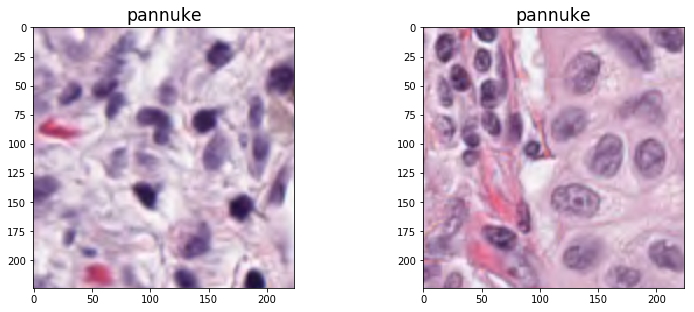

In [51]:
figsize = (12.8, 4.8)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
axes[0].set_title(heatmaps_list[0]['type'], size='xx-large')
axes[1].set_title(heatmaps_list[1]['type'], size='xx-large')
axes[0].imshow(np.asarray(heatmaps_list[0]['original'], dtype=np.uint8))
axes[1].imshow(np.asarray(heatmaps_list[1]['original'], dtype=np.uint8))
plt.show()


In [33]:
for i in range(len(heatmaps_list)):
    print heatmaps_list[i]['path']

pannuke, pannuke/fold3/509/normal/center/patch, 0, train


In [22]:
for i in range(len(heatmaps_list[:])):
    if 'normal' in heatmaps_list[i]['path']:
        k = 'normal'
    else:
        k='tumor' #heatmaps_list[i]['path'].split(', ')[1]#.split('/')[0]
    print k
    heatmaps_list[i]['type']=k

normal
normal
tumor
tumor


In [23]:
heatmaps_list[3].keys()

['rep9',
 'rep8',
 'rep7',
 'rep6',
 'rep5',
 'rep4',
 'rep3',
 'rep2',
 'rep1',
 'rep0',
 'rep19',
 'rep18',
 'rep13',
 'pred',
 'rep11',
 'rep10',
 'rep17',
 'rep16',
 'rep15',
 'rep14',
 'type',
 'path',
 'rep24',
 'rep22',
 'rep23',
 'rep20',
 'rep21',
 'rep12',
 'original']

In [43]:
for heatmaps in heatmaps_list[:]:
    for r in range(rep):
        compute_avg(heatmaps['rep{}'.format(r)])
        #compute_squaregrid(heatmaps['rep{}'.format(r)])

In [47]:
heatmaps_list[-1].keys()

['path', 'pred', 'type', 'original', 'rep0']

In [191]:
h['path']

'pannuke, pannuke/fold3/509/normal/center/patch, 0, train'

In [58]:
for h in heatmaps_list[:]:
    print '\n'+h['path'], h['pred']
    if 'normal' in h['path']:
        type_ ='normal'
    else:
        type_='tumor'
    
    for m in ['SLIC', 'Felzenszwalb']:#, 'AVG']:
        #print m+'\n'
        list_ = []
        for rep in range(1,10):
            #print rep, ssim(h['rep0'][m], h['rep{}'.format(rep)][m])
            list_.append(ssim(h['rep{}'.format(rep-1)][m], h['rep{}'.format(rep)][m]))
        print m, np.mean(list_), np.std(list_)


pannuke, pannuke/fold3/509/normal/center/patch, 0, train [12.406976]
SLIC 0.5647791215136039 0.02333015291245008
Felzenszwalb 0.22287148921484137 0.024063779741244972

pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train [9.633596]
SLIC 0.39666236342240124 0.030369871100641817
Felzenszwalb 0.2144150308193974 0.026366819848053225


pannuke/fold3/509/normal/center/


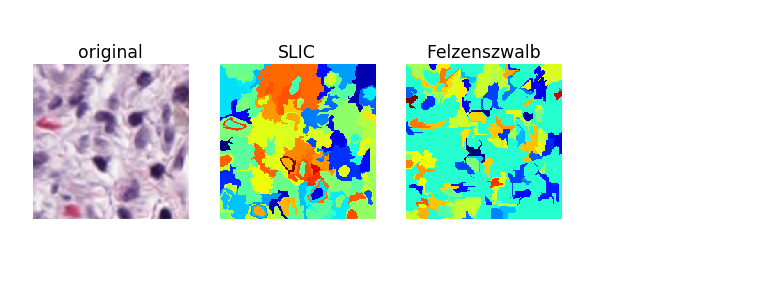

In [105]:
img_idx=0
alpha=0.8
figsize = (12.8, 4.8)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
axes[0].set_title('original', size='xx-large')
axes[1].set_title('SLIC', size='xx-large')
axes[2].set_title('Felzenszwalb', size='xx-large')
#axes[3].set_title('Quickshift', size='xx-large')
#axes[3].set_title('AVG', size='xx-large')

path = heatmaps_list[img_idx]['path'].split(', ')[1][:-5]
print path
masks = data['pannuke'][path+'mask'][0]
img = np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
#binary_masks = binarize_all_masks(masks)

#axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
axes[0].imshow(np.asarray(heatmaps_list[img_idx]['original'],dtype=np.uint8))

axes[1].imshow(heatmaps_list[img_idx]['rep0']['SLIC'], cmap='jet')
axes[2].imshow(heatmaps_list[img_idx]['rep6']['Felzenszwalb'], cmap='jet')
#axes[3].imshow(heatmaps_list[img_idx]['AVG'], cmap='jet')

for i in range(4):
    axes[i].axis('off')
plt.show()
